In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
class SimpleMultiClassBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=50):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.learners = []
        self.learner_weights = []
        self.label_encoder = LabelEncoder()
        self.n_classes = 0

    def fit(self, X, y):
        # Convert labels to [0, self.n_classes-1]
        y_true = self.label_encoder.fit_transform(y)
        self.n_classes = len(y.unique())

        # Initialize weights uniformly
        rows, _ = X.shape
        weights = []
        [weights.append(1/rows) for i in range(rows)]

        for _ in range(self.n_estimators):
            
            learner = DecisionTreeClassifier(max_depth=1)
            learner.fit(X, y_true, sample_weight=weights)
            # Compute weighted learner_erroror rate (misclassification rate)
            y_pred = learner.predict(X)

            learner_error = 0
            for i in range(y_true.size):
                if y_true[i] != y_pred[i]:
                    learner_error += weights[i]
            # Compute learner weight using SAMME algorithm
            alpha = 0.5 * np.log((1-learner_error) / learner_error)
            if learner_error >= 1 - (1 / self.n_classes):
                break  # Stop if the learner is no better than random guessing

            # Increase the weights of misclassified samples
            z_t = 0.0
            
            for i in range(len(weights)):
                updated_weight = 0.0
                if y_true[i] == y_pred[i]:
                    updated_weight = weights[i] * np.exp(-1*alpha)
                else:
                    updated_weight = weights[i] * np.exp(alpha)
                
                z_t += updated_weight
                weights[i] = updated_weight

            weights /= z_t
            
            learner_weight = alpha
            # Save the current learner
            self.learners.append(learner)
            self.learner_weights.append(learner_weight)

    def predict(self, X : pd.DataFrame):
        rows, _ = X.shape
        y_prob = [ClassificationProbability(self.n_classes) for _ in range(rows)]

        # Collect predictions from each learner
        for i in range(len(self.learners)):
            y_pred = self.learners[i].predict(X)
            [y_prob[j].update_probabilities(y_pred[j], self.learner_weights[i]) for j in range(y_pred.size)]

        
        # Final prediction is the one with the highest weighted vote
        y_pred = []
        [y_pred.append(y_prob[i].choose_class()) for i in range(len(y_prob))]
        y_pred = np.array(y_pred)

        # Convert back to original class labels
        y_pred = self.label_encoder.inverse_transform(y_pred)
        return y_pred
    
class ClassificationProbability():
    def __init__(self, n : int):
        self.probability = []
        [self.probability.append(0) for i in range(n)]

    def update_probabilities(self, i : int, alpha: float):
        self.probability[i] += alpha

    def choose_class(self):
        return np.argmax(self.probability)

Load Data set

In [13]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)  
iris_df['target'] = iris.target
X = iris_df.drop("target", axis=1)
y = iris_df["target"]
type(y)

pandas.core.series.Series

Train

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8)
classifier = SimpleMultiClassBoosting(n_estimators=50)
classifier.fit(X_train, y_train)

Test

accuracy : 0.9111111111111111


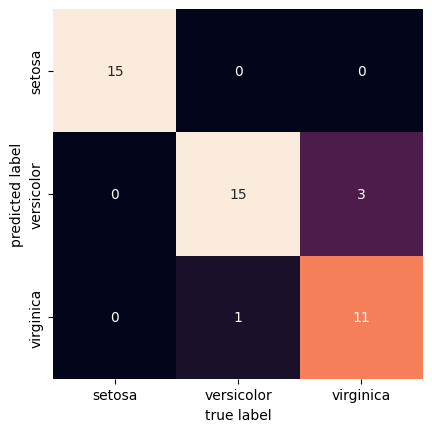

In [15]:
y_pred = classifier.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_mtx.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
print(f"accuracy : {accuracy_score(y_test, y_pred)}")